# PS2: Future Share Price Prediction using a Trinomial Lattice Model
Fill me in

## Setup
Set up the computational environment using [the `Include.jl` file](Include.jl). The [`Include.jl` file](Include.jl) loads external packages, various functions we will use in the exercise, and custom types to model the components of our example problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). This problem set __does not depend__ upon [the VLQuantitativeFinancePackage.jl package](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl).

In [3]:
include("Include.jl");

## Prerequisites: Load and clean the historical dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2018` until `12-29-2023`, along with data for a few exchange-traded funds and volatility products during that time. We load the `orignal_training_dataset` by calling [the `MyTrainingMarketPriceDataSet()` function](src/Files.jl):

In [5]:
original_training_dataset = MyTrainingMarketPriceDataSet() |> x-> x["dataset"];

### Clean the data
Not all tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquisition or de-listing events. Let's collect only those tickers with the maximum number of trading days.

* First, let's compute the number of records for a company that we know has a maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days` variable:

In [7]:
maximum_number_trading_days = original_training_dataset["AAPL"] |> nrow;

Now, let's iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `training)dataset::Dict{String,DataFrame}` variable:

In [9]:
training_dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_training_dataset
    if (nrow(data) == maximum_number_trading_days)
        training_dataset[ticker] = data;
    end
end
training_dataset

Dict{String, DataFrame} with 460 entries:
  "NI"   => 1508×8 DataFrame…
  "EMR"  => 1508×8 DataFrame…
  "CTAS" => 1508×8 DataFrame…
  "HSIC" => 1508×8 DataFrame…
  "KIM"  => 1508×8 DataFrame…
  "PLD"  => 1508×8 DataFrame…
  "IEX"  => 1508×8 DataFrame…
  "BAC"  => 1508×8 DataFrame…
  "CBOE" => 1508×8 DataFrame…
  "EXR"  => 1508×8 DataFrame…
  "NCLH" => 1508×8 DataFrame…
  "CVS"  => 1508×8 DataFrame…
  "DRI"  => 1508×8 DataFrame…
  "DTE"  => 1508×8 DataFrame…
  "ZION" => 1508×8 DataFrame…
  "AVY"  => 1508×8 DataFrame…
  "EW"   => 1508×8 DataFrame…
  "EA"   => 1508×8 DataFrame…
  "NWSA" => 1508×8 DataFrame…
  "CAG"  => 1508×8 DataFrame…
  "GPC"  => 1508×8 DataFrame…
  "FCX"  => 1508×8 DataFrame…
  "GILD" => 1508×8 DataFrame…
  "UNP"  => 1508×8 DataFrame…
  "CDW"  => 1508×8 DataFrame…
  ⋮      => ⋮

Next, let's get a list of firms that we have in cleaned up `training_dataset` and save it in the `list_of_all_tickers` array

In [11]:
list_of_all_tickers = keys(training_dataset) |> collect |> sort;

### Constants
Finally, let's set some constants we'll use later in this notebook. The comments describe the constants, the units, permissible values, etc.

In [13]:
Δt = (1/252);

## Task 1: Estimate the real-world lattice parameters from data
Fill me in.

In [15]:
log_growth_array = log_growth_matrix(training_dataset,  list_of_all_tickers, Δt = Δt);

Fill me in

In [17]:
ticker_to_analyze = "SPY";

Fill me in

In [19]:
i = findfirst(ticker -> ticker == ticker_to_analyze, list_of_all_tickers);
parameters = (RealWorldTrinomialProbabilityMeasure())(log_growth_array[:,i], ϵ = 0.05)

MyRealWorldTrinomialSharePriceTreeParameters(0.5428002654280026, 0.42866622428666223, 0.028533510285335104, 1.0068122600524767, 0.992366459291719, 0.05, 0.003968253968253968)

### Check: Do the estimated probabilities sum to `1`?
Fill me in

In [21]:
let 
    p = parameters.p;
    p̄ = parameters.p̄
    q = parameters.q;

    @show (p, p̄, q)
    @assert (p + p̄ + q) == 1
end

(p, p̄, q) = (0.5428002654280026, 0.42866622428666223, 0.028533510285335104)


## Task 2: Build a trinomial model and test in-sample performance
Fill me in

In [23]:
h = 13; # will give h + 1 levels with index {0,1,...,h-1} because zero-based

Select a random `h-day` period 

In [25]:
random_start_index = rand(1000:(maximum_number_trading_days - h));
random_stop_index = random_start_index + (h - 1);
(random_start_index, random_stop_index)

(1079, 1091)

In [26]:
Sₒ = original_training_dataset[ticker_to_analyze][random_start_index,:volume_weighted_average_price]

440.2705

Fill me in

In [28]:
latticemodel = build(MyAdjacencyBasedTrinomialSharePriceTreeModel, parameters) |> model -> populate(model, Sₒ = Sₒ, h = h);

#### Check: Visualize price distribution at tree level `h`

In [30]:
let
    L = 2;
    nodeid = latticemodel.levels[L]
    df = DataFrame();
    for i ∈ nodeid
        node = latticemodel.data[i];
        
        row_df = (
            index = i,
            probability = node.probability,
            price = node.price,
            path = node.path,
        );
        push!(df, row_df);
    end
    pretty_table(df)
end

┌───────┬─────────────┬─────────┬──────────────┐
│ index │ probability │   price │         path │
│ Int64 │     Float64 │ Float64 │ Vector{Char} │
├───────┼─────────────┼─────────┼──────────────┤
│     4 │    0.294632 │ 443.803 │   ['a', 'a'] │
│     5 │    0.030976 │ 442.033 │   ['a', 'b'] │
│     6 │     0.46536 │ 440.296 │   ['a', 'c'] │
│     7 │    0.030976 │ 442.033 │   ['b', 'a'] │
│     8 │ 0.000814161 │ 440.271 │   ['b', 'b'] │
│     9 │   0.0244627 │  438.54 │   ['b', 'c'] │
│    10 │     0.46536 │ 440.296 │   ['c', 'a'] │
│    11 │   0.0244627 │  438.54 │   ['c', 'b'] │
│    12 │    0.183755 │ 436.817 │   ['c', 'c'] │
└───────┴─────────────┴─────────┴──────────────┘


### Check: Does the probability of _unique nodes_ on a level sum to `1`?
Fill me in.

In [32]:
let
    L = h;
    nodeid = latticemodel.levels[L]
    probability_array = Array{Float64,1}();
    for i ∈ nodeid
        node = latticemodel.data[i];
        probability = node.probability;
        if ((probability ∈ probability_array) == false)
            push!(probability_array,probability);
        end
    end
    @assert sum(probability_array) ≈ 1 # \approx function, 
end;

### Visualize trinomial lattice simulation
Next, look at how the binomial model simulations compare with market observations. In particular, we'll compute the expected value and the variance of the simulated price as a function of time, i.e., at each level in the tree using the local [`𝔼(...)`](src/Compute.jl) and [`Var(...)` functions](src/Compute.jl).
* The `levels` array holds the index of the tree levels, i.e., the time slices. The [`𝔼(...)`](src/Compute.jl) and [`Var(...)` functions](src/Compute.jl) take the `random_test_model` tree model, and the `levels` array and return the expectation and the variance, respectively. 

In [34]:
levels = [k for k ∈ 0:(h-1)]
expectation = 𝔼(latticemodel, levels); # compute the expected value
variance = Var(latticemodel, levels);

#### Summary
`Unhide` the code block below to see how we plotted the model simulations and the observed prices for a randomly selected firm using a binomial lattice model.
* Depending upon the random ticker, the observed price (red line) may or may not lie in the $\pm\,{z}\cdot\sigma$ confidence ranges, where `z = {1,1.96,2.576}` which are shown in progressively lighter shades of blue. The dashed dark blue line shows the expected value.

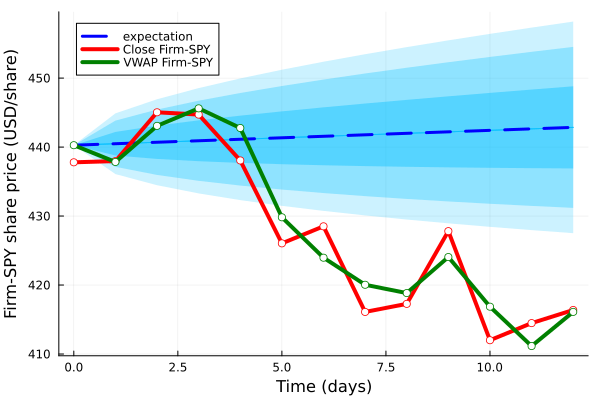

In [36]:
let 
    L68 = expectation[:,2] .- sqrt.(variance[:,2])
    U68 = expectation[:,2] .+ sqrt.(variance[:,2])
    L95 = expectation[:,2] .- 1.96*sqrt.(variance[:,2])
    U95 = expectation[:,2] .+ 1.96*sqrt.(variance[:,2])
    L99 = expectation[:,2] .- 2.576*sqrt.(variance[:,2])
    U99 = expectation[:,2] .+ 2.576*sqrt.(variance[:,2])


    T_range = range(random_start_index,stop=random_stop_index,step=1) |> collect
    random_firm_data = original_training_dataset[ticker_to_analyze]
    key = :close
    
    plot(expectation[:,1], expectation[:,2], fillrange=L68, c=:deepskyblue1, alpha=0.4, label="")
    plot!(expectation[:,1], expectation[:,2], fillrange=U68, c=:deepskyblue1, alpha=0.4, label="")
    plot!(expectation[:,1], expectation[:,2], fillrange=L95, c=:deepskyblue1, alpha=0.3, label="")
    plot!(expectation[:,1], expectation[:,2], fillrange=U95, c=:deepskyblue1, alpha=0.3, label="")
    plot!(expectation[:,1], expectation[:,2], fillrange=L99, c=:deepskyblue1, alpha=0.2, label="")
    plot!(expectation[:,1], expectation[:,2], fillrange=U99, c=:deepskyblue1, alpha=0.2, label="")
    plot!(expectation[:,1], expectation[:,2], c=:blue, lw=3,ls=:dash, label="expectation")
    
    # data - close
    plot!(expectation[:,1], random_firm_data[T_range, key],  
        lw=4, c=:red, label="Close Firm-$(ticker_to_analyze)", legend = :topleft)
    scatter!(expectation[:,1], random_firm_data[T_range, key], label="", 
        msc=:red, mc=:white)

    # data - vwap
    plot!(expectation[:,1], random_firm_data[T_range, :volume_weighted_average_price],  
        lw=4, c=:green, label="VWAP Firm-$(ticker_to_analyze)", legend = :topleft)
    scatter!(expectation[:,1], random_firm_data[T_range, :volume_weighted_average_price], label="", 
        msc=:green, mc=:white)

    xlabel!("Time (days)", fontsize=18)
    ylabel!("Firm-$(ticker_to_analyze) share price (USD/share)", fontsize=18)
end

## Task 3: Out of sample trinomial model testing
Fill me in

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.